# Kennicott and Root Glaciers flux gate method

Data inputs: 

- elevation change
- ice thickness
- surface velocity
- glacier outline

Flux gate positions are specified by start and end coordinates. Flux gates are simulated above and below the drawn gates, and results are computed for all combinations of flux gates around these points.

In [1]:
from tkinter import *
import os, warnings, math, rasterio, shapely
from tqdm import tqdm
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely.ops import split
import rioxarray as rxr
from rasterio.warp import Resampling
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import cmocean

from raster_basics.RasterBasics import rOpen, show_fig, rasterMath, shpReprojection, shpClip, tifReprojectionResample, rasterLike
from raster_basics.RasterBasics import extract_along_line, end_points


In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

### Import Files

In [3]:
# outline file (make sure this is in the right crs)
shp_fp = '/path/to/1957_outline_kennicott.gpkg' # 1957 Kennicott outline
# shp_fp = '/path/to/1957_outline_root.gpkg' # 1957 Root outline


In [4]:
# ice thickness -- from glacier bed and DEMs
bed_fp_init = '/path/to/bed.tif'


In [5]:
# filepaths (clipped by shapefile & set to the same resolution and extent)
# elevation change files
dhdt_fp_1938_out = 'dhdt_1938.tif' # 1938-1957
dhdt_fp_1957_out = 'dhdt_1957.tif' # 1957-1978
dhdt_fp_1978_out = 'dhdt_1978.tif' # 1978-2004
dhdt_fp_2004_out = 'dhdt_2004.tif' # 2004-2012
dhdt_fp_2023_out = 'dhdt_2023.tif' # 2012-2023

# ice thickness files
h_fp_1938_out = 'h_1938.tif'
h_fp_1957_out = 'h_1957.tif'
h_fp_1978_out = 'h_1978.tif'
h_fp_2004_out = 'h_2004.tif'
h_fp_2012_out = 'h_2012.tif'
h_fp_2023_out = 'h_2023.tif'

# velocity files
vx_fp_1960_out = 'vx_1960.tif' # generated in this study from feature-tracking
vy_fp_1960_out = 'vy_1960.tif'
vx_fp_1990_out = 'vx_1990.tif' # this and below are from ITS_LIVE
vy_fp_1990_out = 'vy_1990.tif'
vx_fp_2008_out = 'vx_2008.tif' 
vy_fp_2008_out = 'vy_2008.tif'
vx_fp_2017_out = 'vx_2017.tif' 
vy_fp_2017_out = 'vy_2017.tif'


### Calculate Flux Gate Values


The volume of ice through flux gates should, theoretically, conserve mass. Thus, any difference in the volume of ice through upstream and downstream gates is the flux divergence:

<center>$u_{divQ}=(V_{in}-V_{out})/A$</center>

The resulting climatic mass balance is:

<center>$b_{cmb}=dh/dt-u_{divQ}$</center>

    
NOTE: following these equations, positize $u_{divQ}$ is **emergence**

In [15]:
def incremental_dist(dist):
    # get the distance represented by each point along our flux gate
    divider_dist = [(dist[i] + dist[i+1])/2 for i in range(len(dist)-1)]
    divider_dist.insert(0, dist[0])
    divider_dist.append(dist[-1])
    
    # incremental distance between values
    inc_dist = [divider_dist[i+1] - divider_dist[i] for i in range(len(divider_dist)-1)]  
    assert sum(inc_dist) == dist[-1], 'Issue with inc_dist. Sum of incremental distance must equal total distance'
    return inc_dist


In [16]:
def flux_gate_divq_calc(area, vhd_in, vhd_out, mean_dhdt):
    # Calculate flux divergence for mass balance gate zones
        # area: MB zone area (m2)
        # vhd_in, vhd_out: total ice volume flux in and out (m3/yr)
        # mean_dhdt: zone average dhdt
    if vhd_in == None:
        print('\nNo flux enters this zone!\n')
        vhd_in = 0
    if vhd_out == None:
        print('\nNo flux exits this zone!\n')
        vhd_out = 0
        
    flux_dhdt = (vhd_in - vhd_out)/area # flux divergence (m/yr) (positive is emergence; negative is submergence)
    cmb = mean_dhdt - flux_dhdt 
    return cmb, flux_dhdt


In [17]:
def remove_offglacier(vals, dist, coord, removal_val):
    # remove off-glacier values from list
    vals_filt = [v for v in vals if v != removal_val]
    coord_filt = [c for v, c in zip(vals, coord) if v != removal_val]
    dist_temp = [d for v, d in zip(vals, dist) if v != removal_val]
    dist_filt = [d - dist_temp[0] for d in dist_temp]
    return vals_filt, dist_filt, coord_filt


In [18]:
def vals_along_line(stored_xvals, stored_yvals, tiff, offglacier_val):
    # extract raster values along the line
    line_points = list(zip(stored_xvals, stored_yvals))
    line = shapely.geometry.MultiLineString([[[p[0],p[1]] for p in line_points]])
    xarr = rxr.open_rasterio(tiff).squeeze()
    profile, coordinate = extract_along_line(xarr, line, method='ffill')
    points = end_points(xarr, line_points, method='ffill')

    # get the raster values along the line and the distances along the transect
    vals = [float(x) for x in profile]
    line_dists = [[coordinate[i], coordinate[i+1]] for i in range(len(coordinate)-1)]
    dist = [math.dist(pair[0], pair[1]) for pair in line_dists]
    dist = [sum(dist[:i]) for i in range(len(dist)+1)]

    # remove off-glacier values
    vals_filt, dist_filt, coord_filt = remove_offglacier(vals, dist, coordinate, offglacier_val)

    # calculate the aspect or angle of the line at each point      
    angle_deg = get_angle(line_points)

    return vals_filt, dist_filt, angle_deg, coord_filt


In [19]:
def partition_shp(shp_file_in, shp_file_out, line):
    shp_gdf = gpd.read_file(shp_file_in) # get the input shapefile
    partitioned_geometries = shp_gdf['geometry'].apply(lambda geom: split(geom, line)) # split shapefile geometry
    partitioned_gdf = gpd.GeoDataFrame(geometry=partitioned_geometries.explode(index_parts=False))
    partitioned_gdf.to_file(shp_file_out) # save file


In [20]:
def get_angle(line_points):
    change_x = line_points[1][0] - line_points[0][0]
    change_y = line_points[1][1] - line_points[0][1]
    angle_rad = math.atan2(change_y, change_x)

    angle_deg = math.degrees(angle_rad) - 90 # convert and adjust for North as 0 degrees (increases ccs)
    if angle_deg < 0: # adjust aspect to range [0, 360]
        angle_deg += 360
    return angle_deg

In [21]:
def get_perp_points(x1, y1, x2, y2, num_points, mag):
    # get perpendicular points to a line from (x1, y1) to (x2, y2)
    dx = x2 - x1
    dy = y2 - y1
    magnitude = np.sqrt(dx**2 + dy**2)

    # normalize the direction vector
    dx /= magnitude
    dy /= magnitude

    perp_x1, perp_y1, perp_x2, perp_y2 = [], [], [], []
    for i in range(num_points): # get perpendicular points from x2, y2
        t = mag * i / (num_points - 1)
        x = x2 + t * dy
        y = y2 - t * dx
        perp_x2.append(x)
        perp_y2.append(y)
    
    for i in range(num_points): # now, go the other direction (still from x2, y2)
        t = mag * i / (num_points - 1)
        x = x2 - t * dy
        y = y2 + t * dx
        perp_x2.append(x)
        perp_y2.append(y)
        
    perpendicular_points = []
    for i in range(num_points): # get perpendicular points from x1, y1
        t = mag * i / (num_points - 1)
        x = x1 + t * dy
        y = y1 - t * dx
        perp_x1.append(x)
        perp_y1.append(y)
    
    for i in range(num_points): # now, go the other direction (still from x1, y1)
        t = mag * i / (num_points - 1)
        x = x1 - t * dy
        y = y1 + t * dx
        perp_x1.append(x)
        perp_y1.append(y)

    return perp_x1, perp_y1, perp_x2, perp_y2


In [22]:
def plot_vel_lines(axis, coord0, vx0, vy0, color0, coord1, vx1, vy1, color1, v_mag, v_freq, lw, a, g, i, style='vector'):
    if style == 'vector':
        if g == 'both':
            for (x, y), dx, dy in zip(coord0[::v_freq], vx0[::v_freq], vy0[::v_freq]):
                axis.arrow(x, y, dx*v_mag, dy*v_mag, fc=color0, ec=color0, lw=lw, alpha=a)    
            for (x, y), dx, dy in zip(coord1[::v_freq], vx1[::v_freq], vy1[::v_freq]):
                axis.arrow(x, y, dx*v_mag, dy*v_mag, fc=color1, ec=color1, lw=lw, alpha=a)
        elif g == 'top':
            for (x, y), dx, dy in zip(coord0[::v_freq], vx0[::v_freq], vy0[::v_freq]):
                axis.arrow(x, y, dx*v_mag, dy*v_mag, fc=color0, ec=color0, lw=lw, alpha=a)
            if i == 0:
                for (x, y), dx, dy in zip(coord1[::v_freq], vx1[::v_freq], vy1[::v_freq]):
                    axis.arrow(x, y, dx*v_mag, dy*v_mag, fc=color1, ec=color1, lw=lw, alpha=a)
        elif g == 'bottom':
            if i == 0:
                for (x, y), dx, dy in zip(coord0[::v_freq], vx0[::v_freq], vy0[::v_freq]):
                    axis.arrow(x, y, dx*v_mag, dy*v_mag, fc=color0, ec=color0, lw=lw, alpha=a)
            for (x, y), dx, dy in zip(coord1[::v_freq], vx1[::v_freq], vy1[::v_freq]):
                axis.arrow(x, y, dx*v_mag, dy*v_mag, fc=color1, ec=color1, lw=lw, alpha=a)
    elif style == 'fill':
        x0 = np.array([x for x, y in coord0])
        y0 = np.array([y for x, y in coord0])
        x0_2 = x0 + np.array(vx0)*v_mag
        y0_2 = y0 + np.array(vy0)*v_mag

        x1 = np.array([x for x, y in coord1])
        y1 = np.array([y for x, y in coord1])    
        x1_2 = x1 + np.array(vx1)*v_mag
        y1_2 = y1 + np.array(vy1)*v_mag
        
        if g == 'both':
            axis.fill(np.append(x0, x0_2[::-1]), np.append(y0, y0_2[::-1]), color=color0, lw=None, alpha=a)
            axis.fill(np.append(x1, x1_2[::-1]), np.append(y1, y1_2[::-1]), color=color1, lw=None, alpha=a)

        elif g == 'top':
            axis.fill(np.append(x0, x0_2[::-1]), np.append(y0, y0_2[::-1]), color=color0, lw=None, alpha=a)
            if i == 0:
                axis.fill(np.append(x1, x1_2[::-1]), np.append(y1, y1_2[::-1]), color=color1, lw=None, alpha=a)

        elif g == 'bottom':
            if i == 0:
                axis.fill(np.append(x0, x0_2[::-1]), np.append(y0, y0_2[::-1]), color=color0, lw=None, alpha=a)
            axis.fill(np.append(x1, x1_2[::-1]), np.append(y1, y1_2[::-1]), color=color1, lw=None, alpha=a)

    else:
        print('No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.')
        return
                


In [23]:
def baseplot(fig, ax, shp, geotiff, nan_val, title, xlab, ylab, cmap, vmin, vmax, clabel):
    tiff = rasterio.open(geotiff)
    rast_bounds = tiff.bounds # left, bottom, right, top
    tiff_array = tiff.read(1)
    tiff_array[tiff_array == nan_val] = np.nan

    c = ax.imshow(tiff_array, cmap=cmap, vmin=vmin, vmax=vmax) # plot mosaic
    plt.imshow(tiff_array, cmap=cmap, vmin=vmin, vmax=vmax, 
               extent=[rast_bounds[0], rast_bounds[2], rast_bounds[1], rast_bounds[3]])
    
    ax.grid()
    fig.colorbar(c, label=clabel, ax=ax)
    
    gpd.read_file(shp).plot(ax=ax, edgecolor='k', facecolor='none')
    ax.set_xlim(rast_bounds[0], rast_bounds[2])
    ax.set_ylim(rast_bounds[1], rast_bounds[3])
    ax.add_artist(ScaleBar(1, location='lower left'))
    
    plt.autoscale(False)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    plt.title(title, fontsize=24, c='k')
    

In [24]:
def interp_nan(y):
    # y - y-value with nans (velocity, etc). must have equal distance between values [array]
    yr = np.concatenate(([0], y, [0]))
    y_interp = yr.copy()
    nans = np.isnan(yr) # find nan mask
    y_interp[nans]= np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), yr[~nans]) # interpolate
    y_interp = y_interp[1:-1] # remove excess
    if len(y) != 0:
        nan_frac = np.count_nonzero(np.isnan(y)) / len(y)
    else:
        nan_frac = 0
    return y_interp, nan_frac


In [25]:
def sample_flux_gate_robustness(xvals, yvals, bg_tif, shp, nan_val, dhdt_tifs, h_tifs, vx_tifs, vy_tifs,
                                n_points, magnitude, gate_robustness='both', vel_setting=[10, 10, 0.3, 0, 'vector'], vCol=0.9):
    # xvals, yvals: x and y values of the initial flux gate
    # gate_robustness: which gates to move ('top', 'bottom', or 'both')
    # vel_setting: [vel_mag, vel_freq, vel_a, show_vel_i, vel_style]
        # vel_mag: magnitude to magnify velocity on plot
        # vel_freq: frequency of velocity arrows on plot (n_arrow *= 1/freq)
        # vel_a: alpha value for velocity arrows
        # show_vel_i: which velocity to plot (index in the list)
        # vel_style: plot velocity arrows on flux gates ('vector', 'fill', 'none')
    print('TESTING', n_points, 'TOTAL FLUX GATES OVER A DISTANCE OF', magnitude, 'METERS UPSTREAM AND '
          'DOWNSTREAM FROM INITIAL SELECTION\n')
    dhdt_list, cmb_list, divQ_list, area_list, nan_list = [], [], [], [], []
    h_xs_vals_list = []
    shp_file_out = 'temp_shp_split.shp'
    
    test_point = Point(np.mean(xvals), np.mean(yvals))
    
    if gate_robustness == 'both':
        mag0, mag1 = magnitude, magnitude
    elif gate_robustness == 'top':
        mag0, mag1 = magnitude, 0
    elif gate_robustness == 'bottom':
        mag0, mag1 = 0, magnitude
    elif gate_robustness == 'none':
        mag0, mag1 = 0, 0
        
    x0_1, y0_1, x0_2, y0_2 = get_perp_points(xvals[-2][0], yvals[-2][0], xvals[-2][1], yvals[-2][1], n_points//2, mag0)
    x1_1, y1_1, x1_2, y1_2 = get_perp_points(xvals[-1][0], yvals[-1][0], xvals[-1][1], yvals[-1][1], n_points//2, mag1)
    
    # --- show plot of points ---
    %matplotlib inline
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(16, 10)
    baseplot(fig, ax, shp, bg_tif, nan_val, title='Flux Gate Robustness Points', xlab='UTM Easting (m)',
             ylab='UTM Northing (m)', cmap='Blues', vmin=0, vmax=500, clabel='m')

    plt.plot(xvals[0], yvals[0], color='sienna', ls='-', marker=None, markersize=12, zorder=10, label='Flux Gate In') 
    plt.plot(xvals[1], yvals[1], color='purple', ls=':', marker=None, markersize=12, zorder=10, label='Flux Gate Out')     
    ax.scatter(test_point.x, test_point.y, color='black', marker='*', s=24, label='Test Point', zorder=100)
    # --- end showing plot of points ---
    
    for t in tqdm(range(len(vx_tifs))):  
        dhdt_list_tmp, cmb_list_tmp, divQ_list_tmp, area_list_tmp, nan_list_tmp = [], [], [], [], []
        for i in range(len(x0_1)):
            gpd.read_file(shp).to_file(shp_file_out)
            x_i = [[x0_1[i], x0_2[i]], [x1_1[i], x1_2[i]]]
            y_i = [[y0_1[i], y0_2[i]], [y1_1[i], y1_2[i]]]

            # --- SAMPLING DHDT, H, AND V ALONG FLUX GATES ---
            # sampling the second to last gate
            dhdt0, dist0, a0, coord0 = vals_along_line(x_i[0], y_i[0], dhdt_tifs[t], nan_val)
            h0 = vals_along_line(x_i[0], y_i[0], h_tifs[t], nan_val)[0]
            vx0 = np.array(vals_along_line(x_i[0], y_i[0], vx_tifs[t], nan_val)[0])
            vy0 = np.array(vals_along_line(x_i[0], y_i[0], vy_tifs[t], nan_val)[0])
            vx0, nan_fx0 = interp_nan(vx0) # interpolate actual holes in velocity (e.g., 1960 velocity)
            vy0, nan_fy0 = interp_nan(vy0)
            
            # sampling the last gate
            dhdt1, dist1, a1, coord1 = vals_along_line(x_i[1], y_i[1], dhdt_tifs[t], nan_val)
            h1 = vals_along_line(x_i[1], y_i[1], h_tifs[t], nan_val)[0]
            vx1 = np.array(vals_along_line(x_i[1], y_i[1], vx_tifs[t], nan_val)[0])
            vy1 = np.array(vals_along_line(x_i[1], y_i[1], vy_tifs[t], nan_val)[0])
            vx1, nan_fx1 = interp_nan(vx1)
            vy1, nan_fy1 = interp_nan(vy1)
            
            # filter bad values; replace with 0 (potentially arise in ice thickness file for some reason) 
            h0, vx0, vy0 = zip(*[(h, vx, vy) if abs(h) <= 1e6 and abs(vx) <= 1e6 and abs(vy) <= 1e6 
                                 else (0, 0, 0) for h, vx, vy in zip(h0, vx0, vy0)])
            try:
                h1, vx1, vy1 = zip(*[(h, vx, vy) if abs(h) <= 1e6 and abs(vx) <= 1e6 and abs(vy) <= 1e6 
                                     else (0, 0, 0) for h, vx, vy in zip(h1, vx1, vy1)])
            except:
                h1, vx1, vy1, dist1 = [0]*len(coord0), [0]*len(coord0), [0]*len(coord0), [0]*len(coord0)
                coord1 = [[0, 0]]*len(coord0)
            h0, vx0, vy0 = np.array(h0), np.array(vx0), np.array(vy0)
            h1, vx1, vy1 = np.array(h1), np.array(vx1), np.array(vy1)
            
            # --- FLUX GATE LINES ---
            line0 = LineString([[x0_1[i], y0_1[i]], [x0_2[i], y0_2[i]]])
            line1 = LineString([[x1_1[i], y1_1[i]], [x1_2[i], y1_2[i]]])
            # add lines to plot so we can see
            ax.plot(line0.xy[0], line0.xy[1], color='sienna', linewidth=2, ls='-', alpha=0.3)
            ax.plot(line1.xy[0], line1.xy[1], color='purple', linewidth=2, ls=':', alpha=0.3)

            # --- PLOT VELOCITY LINES ---
            if vel_setting[3] == t:
                plot_vel_lines(ax, coord0, vx0, vy0, 'sienna', coord1, vx1, vy1, 'purple', vel_setting[0], vel_setting[1], 
                               lw=0.5, a=vel_setting[2], g=gate_robustness, i=i, style=vel_setting[4])

            # --- PARTITIONING SHAPE BY LINES ---
            partition_shp(shp_file_out, shp_file_out, line0)
            partition_shp(shp_file_out, shp_file_out, line1)

            # --- POINT FLUX GATE AREA AND MEAN DHDT ---
            # gate area
            contains_point_mask = gpd.read_file(shp_file_out).geometry.contains(test_point)
            partitions_with_point = gpd.read_file(shp_file_out)[contains_point_mask]
            flux_gate_area = float(partitions_with_point.geometry.area) # sq.meters

            # mean elevation change within the partitioned area
            mask = geometry_mask(partitions_with_point.geometry, out_shape=rOpen(dhdt_tifs[t]).shape, 
                                 transform=rasterio.open(dhdt_tifs[t]).transform, invert=True)
            values_within_geometry = np.ma.masked_array(rOpen(dhdt_tifs[t]), mask=~mask)
            values_within_geometry = np.ma.masked_values(values_within_geometry, nan_val) # remove nan_val that still remain
            mean_dhdt_area = values_within_geometry.mean() # calculate the mean of values within the geometry

            # --- ICE FLUX DIVERGENCE CALCULATION ---
            # flux volume in
            v0 = np.sqrt((vCol*vx0)**2 + (vCol*vy0)**2)
            inc_dist0 = incremental_dist(dist0) # get the distance values
            cos_aspect0 = np.cos(np.radians(90) - np.deg2rad(a0)) # get the line aspect at each point
            sin_aspect0 = np.sin(np.radians(90) - np.deg2rad(a0))

            v0[v0 < 1e-6] = 1e-6
            angle_ratio0 = abs((vx0 * sin_aspect0 + vy0 * cos_aspect0) / v0)
            angle_ratio0[v0 < 1e-6] = 0
            vhd0 = [v*h*d*df for v, h, d, df in zip(v0, h0, inc_dist0, angle_ratio0)] # flux gate calculation
            total_vhd0 = sum(vhd0) # Vol. ice flux (m^3/yr)

            # flux volume out
            v1 = np.sqrt((vCol*vx1)**2 + (vCol*vy1)**2)
            inc_dist1 = incremental_dist(dist1) # get the distance values
            cos_aspect1 = np.cos(np.radians(90) - np.deg2rad(a1)) # get the line aspect at each point
            sin_aspect1 = np.sin(np.radians(90) - np.deg2rad(a1))

            v1[v1 < 1e-6] = 1e-6
            angle_ratio1 = abs((vx1 * sin_aspect1 + vy1 * cos_aspect1) / v1)
            angle_ratio1[v1 < 1e-6] = 0

            vhd1 = [v*h*d*df for v, h, d, df in zip(v1, h1, inc_dist1, angle_ratio1)] # flux gate calculation
            total_vhd1 = sum(vhd1) # Vol. ice flux (m^3/yr)

            # FINAL CMB AND DIVQ
            cmb, divQ = flux_gate_divq_calc(flux_gate_area, total_vhd0, total_vhd1, mean_dhdt_area)
            dhdt_list_tmp.append(mean_dhdt_area)
            cmb_list_tmp.append(cmb)
            divQ_list_tmp.append(divQ)
            area_list_tmp.append(flux_gate_area)
            nan_list_tmp.append(max(nan_fx0, nan_fy0, nan_fx1, nan_fy1))
            
        dhdt_list.append(dhdt_list_tmp)
        cmb_list.append(cmb_list_tmp)
        divQ_list.append(divQ_list_tmp)
        area_list.append(area_list_tmp)
        nan_list.append(nan_list_tmp)

    ax.legend()
    plt.show()
    return dhdt_list, cmb_list, divQ_list, area_list, nan_list
    

### Calculate flux gates

In [7]:
class FluxGate:
    def __init__(self):
        self.vCol = 0.9

flux_gate = FluxGate()


In [28]:
# PRESCRIBE FLUX GATE LOCATIONS
# KENNICOTT GLACIER:
flux_gate.all_stored_xvals = [[390716.8419463931, 395880.6918015883],[392153.1981954502, 397653.96545887727],
                              [394469.3107274195, 399789.1316992865],[394903.58182716375, 400585.2953821509],
                              [395583.89196646557, 398449.30550030014]]
flux_gate.all_stored_yvals = [[6819940.245615946, 6823435.869757311], [6817609.399169076, 6821626.40684171],
                              [6816378.964386468, 6818839.833951685],[6815329.475895419, 6815365.665153731],
                              [6812474.737101233, 6812517.374745279]]
flux_gate.asci_list = [['A', "A'"], ['B', "B'"], ['C', "C'"], ['D', "D'"], ['E', "E'"]]

# # ROOT GLACIER:
# flux_gate.all_stored_xvals = [[396289, 399286], [396164, 399147], [395871, 399370], [397668, 399494]]
# flux_gate.all_stored_yvals = [[6825027, 6824957], [6823707, 6823586], [6822041, 6821930], [6819004, 6818713]]
# flux_gate.asci_list = [['E', "E'"], ['F', "F'"], ['G', "G'"], ['H', "H'"]]


In [6]:
# specify data for each time period
dhdt_tifs = [dhdt_fp_1938_out, dhdt_fp_1957_out, dhdt_fp_1978_out, dhdt_fp_2004_out, dhdt_fp_2023_out]
h_tifs = [h_fp_1938_out, h_fp_1957_out, h_fp_1978_out, h_fp_2004_out, h_fp_2023_out]
vx_tifs = [vx_fp_1960_out, vx_fp_1960_out, vx_fp_1990_out, vx_fp_2008_out, vx_fp_2017_out]
vy_tifs = [vy_fp_1960_out, vy_fp_1960_out, vy_fp_1990_out, vy_fp_2008_out, vy_fp_2017_out]


  0%|                                                     | 0/4 [00:00<?, ?it/s]

TESTING 8 TOTAL FLUX GATES OVER A DISTANCE OF 300 METERS UPSTREAM AND DOWNSTREAM FROM INITIAL SELECTION




 60%|███████████████████████████                  | 3/5 [00:33<00:21, 10.89s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



 80%|████████████████████████████████████         | 4/5 [00:44<00:10, 10.98s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



100%|█████████████████████████████████████████████| 5/5 [00:55<00:00, 11.04s/it]


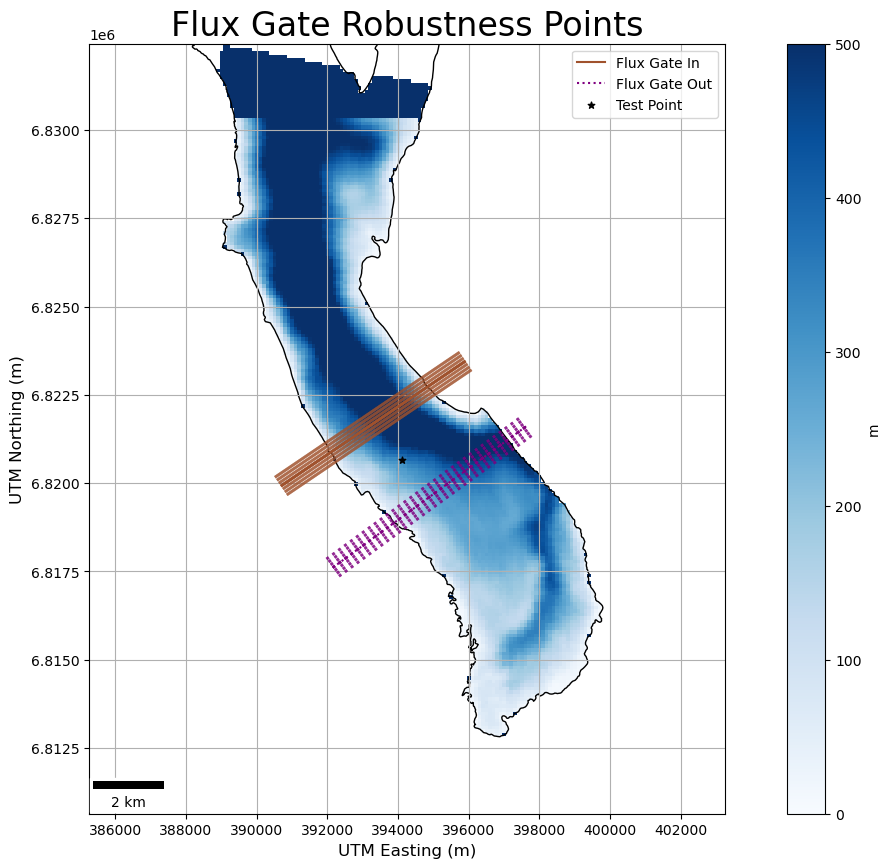

 25%|███████████▎                                 | 1/4 [00:56<02:49, 56.65s/it]

TESTING 8 TOTAL FLUX GATES OVER A DISTANCE OF 300 METERS UPSTREAM AND DOWNSTREAM FROM INITIAL SELECTION




 60%|███████████████████████████                  | 3/5 [00:26<00:17,  8.76s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



 80%|████████████████████████████████████         | 4/5 [00:34<00:08,  8.66s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



100%|█████████████████████████████████████████████| 5/5 [00:43<00:00,  8.66s/it]


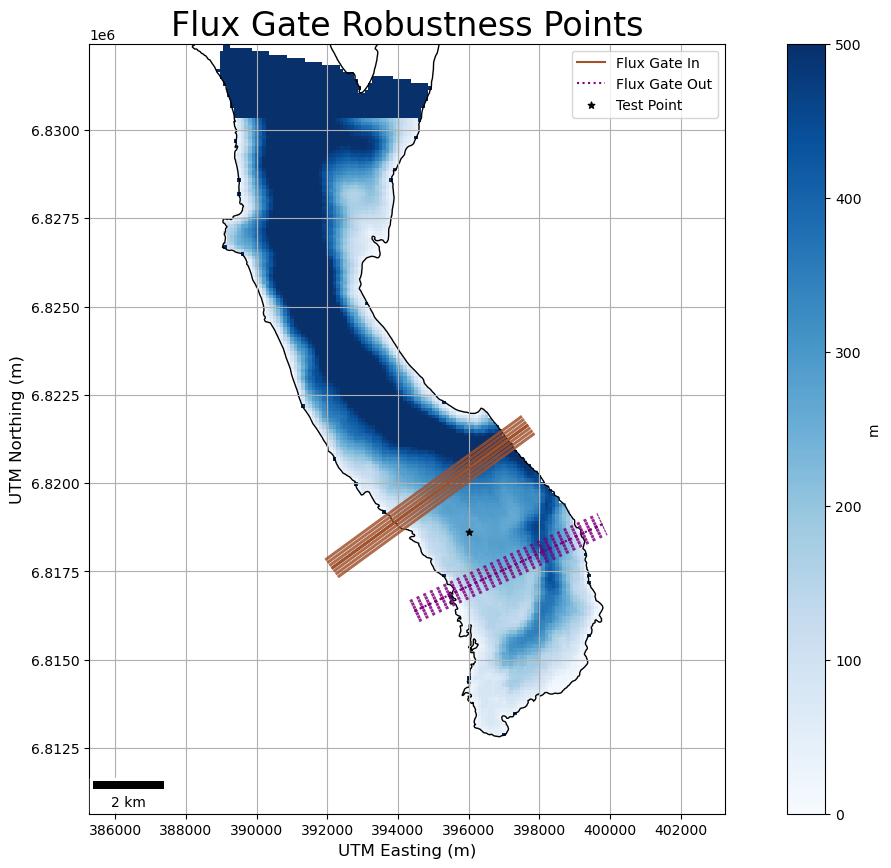

 50%|██████████████████████▌                      | 2/4 [01:40<01:37, 48.91s/it]

TESTING 8 TOTAL FLUX GATES OVER A DISTANCE OF 300 METERS UPSTREAM AND DOWNSTREAM FROM INITIAL SELECTION




 60%|███████████████████████████                  | 3/5 [00:25<00:17,  8.60s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



 80%|████████████████████████████████████         | 4/5 [00:34<00:08,  8.61s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


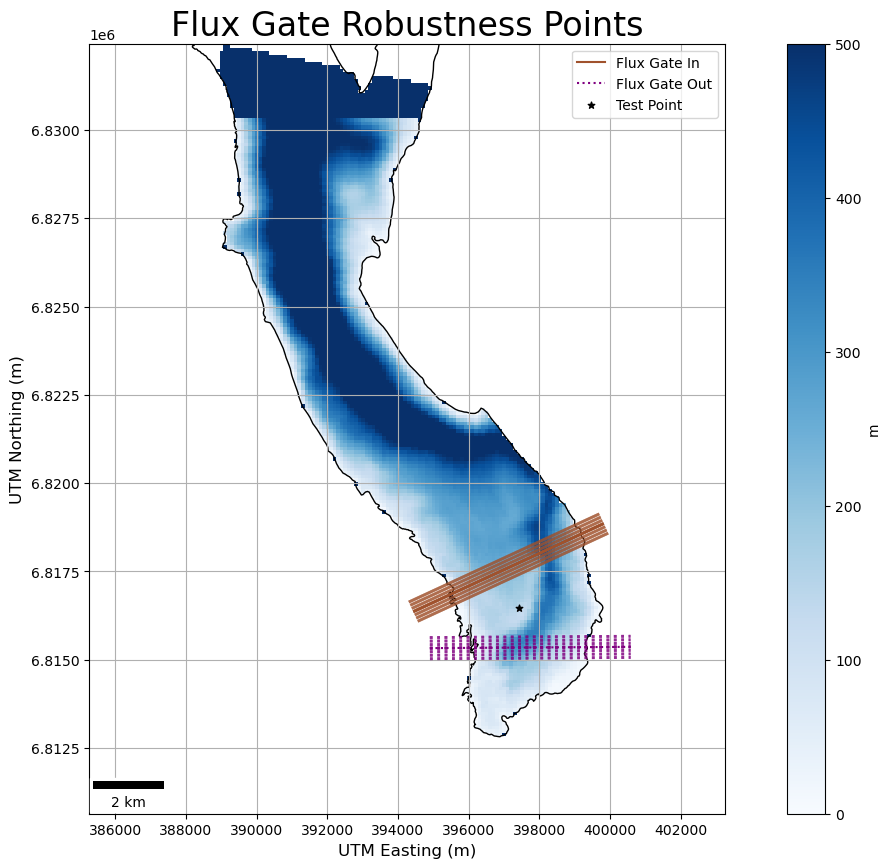

 75%|█████████████████████████████████▊           | 3/4 [02:23<00:46, 46.27s/it]

TESTING 8 TOTAL FLUX GATES OVER A DISTANCE OF 300 METERS UPSTREAM AND DOWNSTREAM FROM INITIAL SELECTION




 60%|███████████████████████████                  | 3/5 [00:25<00:17,  8.53s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.
No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



 80%|████████████████████████████████████         | 4/5 [00:34<00:08,  8.56s/it]

No velocity plotted on flux gates. Select "vector" or "fill" to show velocities on plot.



100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


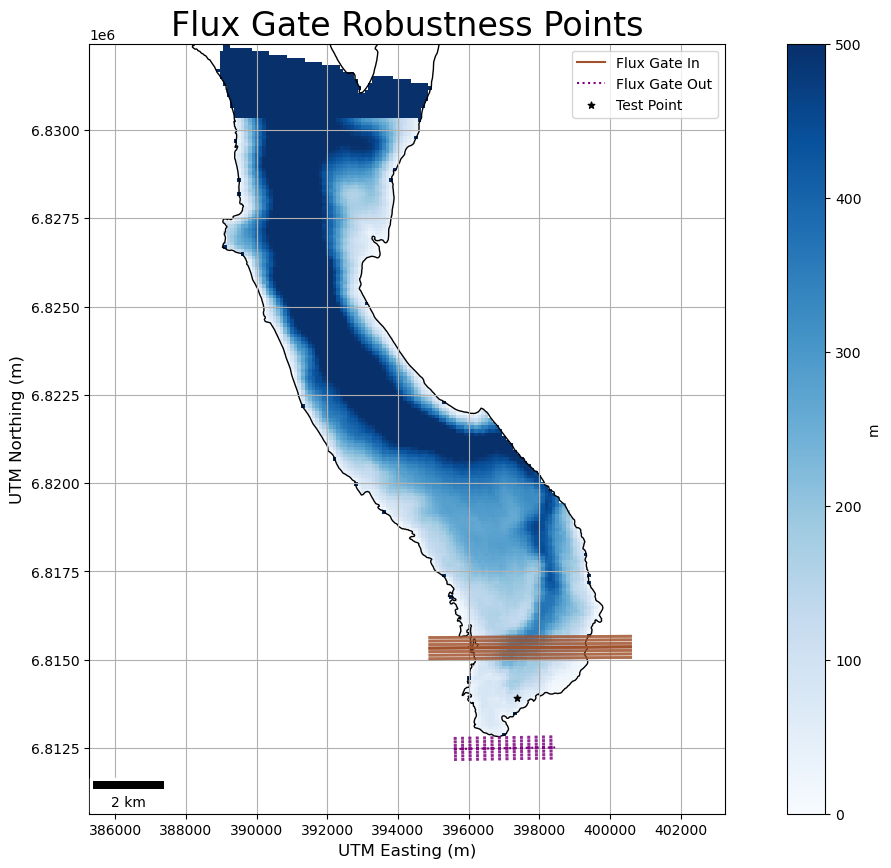

100%|█████████████████████████████████████████████| 4/4 [03:06<00:00, 46.53s/it]


In [29]:
dhdt_robust_list, cmb_robust_list, divQ_robust_list, area_robust_list, nan_robust_list = [], [], [], [], []

for i in tqdm(range(len(flux_gate.all_stored_xvals)-1)):
    stored_xvals = [flux_gate.all_stored_xvals[i], flux_gate.all_stored_xvals[i+1]]
    stored_yvals = [flux_gate.all_stored_yvals[i], flux_gate.all_stored_yvals[i+1]]

    # 1938 (0), 1957 (1), 1978 (2), 2004 (3), 2023 (4)
    robust_results = sample_flux_gate_robustness(stored_xvals, stored_yvals, bg_tif=h_fp_1957,  shp=shp_fp, 
                                                 nan_val=-9999, dhdt_tifs=dhdt_tifs, h_tifs=h_tifs, 
                                                 vx_tifs=vx_tifs, vy_tifs=vy_tifs, n_points=8, magnitude=400,
                                                 gate_robustness='both', vel_setting=[10, 10, 0.4, 3, 'nofill'], vCol=flux_gate.vCol)

    # extract robust flux divergence solutions
    dhdt_robust_list.append(robust_results[0])
    cmb_robust_list.append(robust_results[1])
    divQ_robust_list.append(robust_results[2])
    area_robust_list.append(robust_results[3])
    nan_robust_list.append(robust_results[4])


### Show the values

In [30]:
# median of stable terrain (from co-registration results)
med_38 = -2.69
med_57 = 0.0
med_78 = 0.0
med_04 = 0.48
med_23 = -0.11
med_bias = [med_38, med_57, med_78, med_04, med_23]


In [33]:
year_times = ['1938', '1957', '1978', '2004', '2012']
dhdt_times = ['1938-1957', '1957-1978', '1978-2004', '2004-2012', '2012-2023']
with open('flux_gate_cmb.txt', 'w') as f:
    for g in range(len(dhdt_robust_list)):
        f.write('--------------------------------------------------------------------------------------------------------')
        f.write('\nGATE ' + str(flux_gate.asci_list[g]) + ' TO ' + str(flux_gate.asci_list[g+1]))
        for t in range(len(robust_results[0])):
            f.write('\n\tFOR YEAR ' + year_times[t] + ' (DHDT SPANS ' + dhdt_times[t] + ')')
            f.write(('\n\t\tMean Flux Zone DHDT  [min, max] [st.dev] (m/yr):\t') + str(round(np.mean(np.array(dhdt_robust_list[g][t])), 2)) + ('\t[' +
                    str(round(np.min(np.array(dhdt_robust_list[g][t])), 2)) + ', ' + str(round(np.max(np.array(dhdt_robust_list[g][t])), 2)) + ']\t[' +
                    str(round(np.std(np.array(dhdt_robust_list[g][t])), 2)) + ']'))
            f.write(('\n\t\tMean Calculated DIVQ [min, max] [st.dev] (m/yr):\t') + str(round(np.mean(np.array(divQ_robust_list[g][t])), 2)) + ('\t[' +
                    str(round(np.min(np.array(divQ_robust_list[g][t])), 2)) + ', ' + str(round(np.max(np.array(divQ_robust_list[g][t])), 2)) + ']\t[' +
                    str(round(np.std(np.array(divQ_robust_list[g][t])), 2)) + ']'))
            if np.mean(nan_robust_list[g][t]) != 0:
                f.write('\t [Vel nan %: ' + str(round(np.min(nan_robust_list[g][t]), 3)) + ']')
            f.write(('\n\t\tMean Calculated CMB  [min, max] [st.dev] (m/yr):\t') + str(round(np.mean(np.array(cmb_robust_list[g][t])), 2)) + ('\t[' +
                    str(round(np.min(np.array(cmb_robust_list[g][t])), 2)) + ', ' + str(round(np.max(np.array(cmb_robust_list[g][t])), 2)) + ']\t[' +
                    str(round(np.std(np.array(cmb_robust_list[g][t])), 2)) + ']\n'))
    
        f.write(('\n\tMean Flux Zone Area  [min, max] [st.dev] (sq.km):\t\t') + str(round(np.mean(np.array(area_robust_list[g][0])/1e6), 2)) + ('\t[' 
                 + str(round(np.min(np.array(area_robust_list[g][0])/1e6), 2)) + ', ' + str(round(np.max(np.array(area_robust_list[g][0])/1e6), 2)) 
                 + ']\t[' + str(round(np.std(np.array(area_robust_list[g][0])/1e6), 2)) + ']'))
        f.write('\n--------------------------------------------------------------------------------------------------------\n')
    
    f.write('\n\nNegative DIVQ indicates submergence (assuming the first gate we drew is upstream from the second)')
    f.write('\n\nMedian bias in DEMs in meters (1938, 1957, 1978, 2004, 2023): ' + str(med_38) + ', ' + str(med_57) + ', ' + str(med_78) + ', ' + 
            str(med_04) + ', '+ str(med_23))

with open('flux_gate_cmb.txt', 'r') as f:
    print(f.read())


--------------------------------------------------------------------------------------------------------
GATE ['A', "A'"] TO ['B', "B'"]
	FOR YEAR 1938 (DHDT SPANS 1938-1957)
		Mean Flux Zone DHDT  [min, max] [st.dev] (m/yr):	2.04	[1.97, 2.11]	[0.04]
		Mean Calculated DIVQ [min, max] [st.dev] (m/yr):	3.12	[2.54, 5.61]	[0.98]
		Mean Calculated CMB  [min, max] [st.dev] (m/yr):	-1.08	[-3.64, -0.49]	[1.0]

	FOR YEAR 1957 (DHDT SPANS 1957-1978)
		Mean Flux Zone DHDT  [min, max] [st.dev] (m/yr):	-0.8	[-0.82, -0.79]	[0.01]
		Mean Calculated DIVQ [min, max] [st.dev] (m/yr):	3.57	[2.92, 6.12]	[1.02]
		Mean Calculated CMB  [min, max] [st.dev] (m/yr):	-4.38	[-6.94, -3.72]	[1.02]

	FOR YEAR 1978 (DHDT SPANS 1978-2004)
		Mean Flux Zone DHDT  [min, max] [st.dev] (m/yr):	-0.7	[-0.73, -0.68]	[0.02]
		Mean Calculated DIVQ [min, max] [st.dev] (m/yr):	3.37	[3.01, 4.75]	[0.54]
		Mean Calculated CMB  [min, max] [st.dev] (m/yr):	-4.07	[-5.48, -3.69]	[0.55]

	FOR YEAR 2004 (DHDT SPANS 2004-2012)
		Mean Flux 

### Sample DEM and bed along cross-sections

In [34]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'


In [36]:
# additional filepaths for plotting
dempath_38_fp = 'dem_38.tif' 
dempath_57_fp = 'dem_57.tif' 
dempath_78_fp = 'dem_78.tif'
dempath_2004_fp = 'dem_2004.tif'
dempath_2012_fp = 'dem_2012.tif'
dempath_2018_fp = 'dem_2018.tif'
dempath_2023_fp = 'dem_2023.tif'
bedpath_fp = 'bed.tif'
millan_bedpath_fp = 'thickness_millan.tif'
farinotti_kenn_bedpath_fp ='thickness_farinotti_kenn.tif'
glac_outline_fp = 'outline.tif' # binary raster from shapefile outline


In [37]:
class FluxGateDEM:
    def __init__(self):        
        self.bed_list = []
        self.dist_list = []
        self.glac_mask_list = []
        self.dem1_list = []
        self.dem2_list = []
        self.dem3_list = []
        self.dem4_list = []
        self.dem5_list = []
        self.dem6_list = []
        self.h1_list = []
        self.h2_list = []

    def sample_on_line(self, x, y, bedtiff, shp, vmin, vmax, cmap, clabel, title, nan_val=-9999, dem1=None, 
                       dem2=None, dem3=None, dem4=None, dem5=None, dem6=None, 
                       h1=None, h2=None, outline=None):
        
        # print and store selected values
        for i in range(len(x)):
            geotiff_bed, geotiff_dist, glac_mask = flux_gate_dem.vals_along_line(x[i], y[i], bedtiff, nan_val, outline)
            geotiff_dem1, d1, m1 = flux_gate_dem.vals_along_line(x[i], y[i], dem1, nan_val, outline)
            geotiff_dem2, d2, m2 = flux_gate_dem.vals_along_line(x[i], y[i], dem2, nan_val, outline)
            geotiff_dem3, d3, m3 = flux_gate_dem.vals_along_line(x[i], y[i], dem3, nan_val, outline)
            geotiff_dem4, d4, m4 = flux_gate_dem.vals_along_line(x[i], y[i], dem4, nan_val, outline)
            geotiff_dem5, d5, m5 = flux_gate_dem.vals_along_line(x[i], y[i], dem5, nan_val, outline)
            geotiff_dem6, d6, m6 = flux_gate_dem.vals_along_line(x[i], y[i], dem6, nan_val, outline)
            geotiff_h1, d7, m7 = flux_gate_dem.vals_along_line(x[i], y[i], h1, nan_val, outline)
            geotiff_h2, d8, m8 = flux_gate_dem.vals_along_line(x[i], y[i], h2, nan_val, outline)


            self.bed_list.append(geotiff_bed) # save our distance and value pairs
            self.dist_list.append(geotiff_dist)
            self.glac_mask_list.append(glac_mask)
            self.dem1_list.append(geotiff_dem1)
            self.dem2_list.append(geotiff_dem2) 
            self.dem3_list.append(geotiff_dem3)
            self.dem4_list.append(geotiff_dem4)
            self.dem5_list.append(geotiff_dem5)
            self.dem6_list.append(geotiff_dem6)
            self.h1_list.append(geotiff_h1)
            self.h2_list.append(geotiff_h2)

        
    def vals_along_line(self, x, y, tiff, offglacier_val, outline_tiff):
        # extract raster values along the line
        line_points = list(zip(x, y))
        line = shapely.geometry.MultiLineString([[[p[0],p[1]] for p in line_points]])
        xarr = rxr.open_rasterio(tiff).squeeze()
        res = rasterio.open(tiff).res[0]
        total_dist_est = math.dist(line_points[0], line_points[-1])
        profile, coordinate = extract_along_line(xarr, line, n_samples=int(total_dist_est/res), method='ffill')
        points = end_points(xarr, line_points, method='ffill')

        # get the raster values along the line and the distances along the transect
        vals = [float(x) for x in profile]
        line_dists = [[coordinate[i], coordinate[i+1]] for i in range(len(coordinate)-1)]
        dist = [math.dist(pair[0], pair[1]) for pair in line_dists]
        dist = [sum(dist[:i]) for i in range(len(dist)+1)]
        
        # off-glacier mask
        xarr_o = rxr.open_rasterio(outline_tiff).squeeze()
        profile_o, coord_o = extract_along_line(xarr_o, line, n_samples=int(total_dist_est/res), method='ffill')
        vals_o = [int(x) for x in profile_o]        
        glac_mask = [v != offglacier_val for v in vals_o]
        
        return vals, dist, glac_mask
        

In [38]:
flux_gate_dem = FluxGateDEM()
flux_gate_dem.sample_on_line(flux_gate.all_stored_xvals, flux_gate.all_stored_yvals,
                             bedtiff=bedpath_fp, shp=shp_fp, vmin=0, vmax=2500, cmap='gist_earth', 
                             clabel='Elevation (m)', title='Kennicott and Root Glacier Transects', nan_val=-9999, 
                             dem1=dempath_38_fp, dem2=dempath_57_fp, dem3=dempath_78_fp, dem4=dempath_2004_fp,
                             dem5=dempath_2012_fp, dem6=dempath_2023_fp, 
                             h1=millan_bedpath_fp, h2=farinotti_kenn_bedpath_fp, outline=glac_outline_fp)


In [39]:
# Extract values
for i in range(len(flux_gate_dem.bed_list)): 
    # get the distance values
    name_i = flux_gate.asci_list[i]
    dist_i = flux_gate_dem.dist_list[i] 
    
    # get all of the data values
    bed_i = flux_gate_dem.bed_list[i]
    bed_millan_i = flux_gate_dem.h1_list[i]
    bed_farinotti_kenn_i = flux_gate_dem.h2_list[i]
    dem_38_i = flux_gate_dem.dem1_list[i]
    dem_57_i = flux_gate_dem.dem2_list[i]
    dem_78_i = flux_gate_dem.dem3_list[i]
    dem_2004_i = flux_gate_dem.dem4_list[i]
    dem_2012_i = flux_gate_dem.dem5_list[i]
    dem_2023_i = flux_gate_dem.dem6_list[i]
    
    # filter out nan values (-9999)
    bed_i = [x if x != -9999 else np.nan for x in bed_i]
    bed_millan_i = [x if x != -9999 else np.nan for x in bed_millan_i]
    bed_farinotti_kenn_i = [x if x != -9999 else np.nan for x in bed_farinotti_kenn_i]
    dem_38_i = [x if x != -9999 else np.nan for x in dem_38_i]
    dem_57_i = [x if x != -9999 else np.nan for x in dem_57_i]
    dem_78_i = [x if x != -9999 else np.nan for x in dem_78_i]
    dem_2004_i = [x if x != -9999 else np.nan for x in dem_2004_i]
    dem_2012_i = [x if x != -9999 else np.nan for x in dem_2012_i]
    dem_2023_i = [x if x != -9999 else np.nan for x in dem_2023_i]
    

In [40]:
flux_gate.gate_name_list = ['7.5 - 10 km', '5 - 7.5 km', '2.5 - 5 km', '<2.5 km']
flux_gate.dist_name_list = ['10 km', '7.5 km', '5 km', '2.5 km']


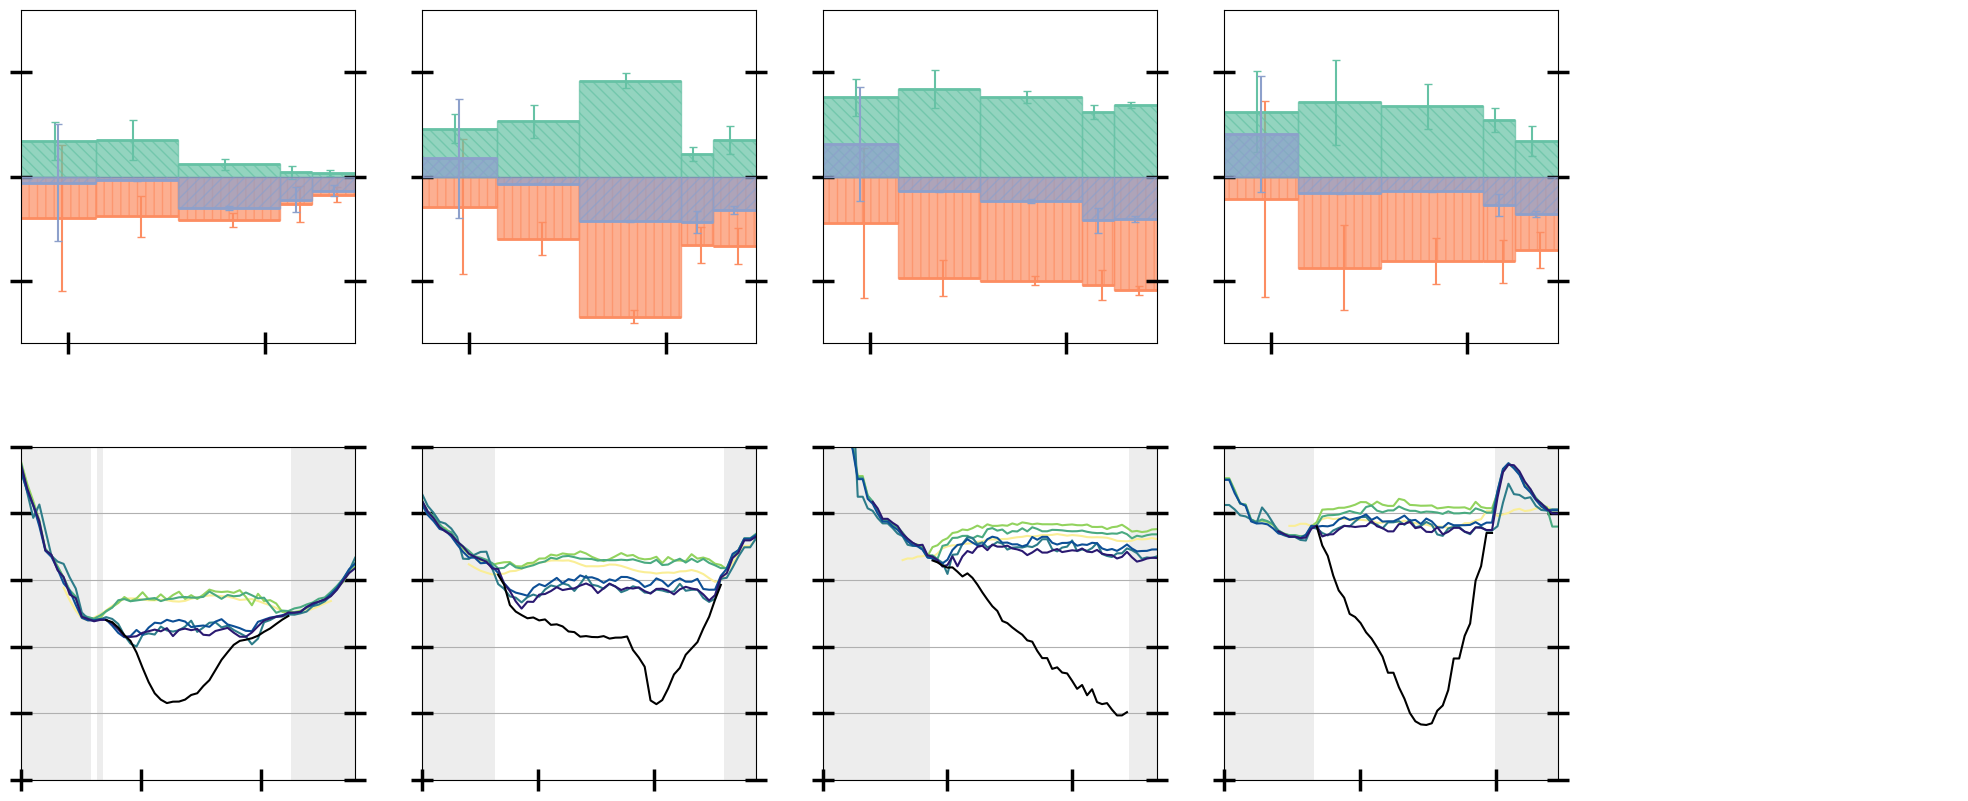

In [41]:
fig, (axt, axb) = plt.subplots(2, len(dhdt_robust_list)+1, figsize=(5*(len(dhdt_robust_list)+1), 2*5), sharey='row')
fig.subplots_adjust(hspace=0.31)

# get gate dates and assign plot colors
full_dates = [int(x) for x in year_times]
full_dates.append(2023)
# colors = ['#74a9cf', 'darkseagreen', 'lightcoral']
colors = ['#8da0cb', '#66c2a5', '#fc8d62']

# get gate labels
gate_labels = [''.join(x) for x in flux_gate.asci_list]
gate_labels = [''.join([gate_labels[i][0], gate_labels[i+1][0]]) for i in range(len(gate_labels)-1)]

# --- --- --- LINE PLOTS --- --- ---
a = 0.7
for i in range(len(dhdt_robust_list)):
    ax_i = len(dhdt_robust_list) - (i+1)
    axt[ax_i].tick_params(axis='y', which='both', direction='inout', left=True, right=True, length=16, width=2.5)
    axt[ax_i].tick_params(axis='x', which='both', direction='inout', bottom=True, top=False, length=16, width=2.5)
    axt[ax_i].axhline(y=0, c='k', ls='-', lw=0.5, alpha=0.75)
    axt[ax_i].fill_between([full_dates[0], full_dates[1]], 0, 0, color=colors[0], hatch='///', alpha=a, label='DHDT', zorder=2)
    axt[ax_i].fill_between([full_dates[0], full_dates[1]], 0, 0, color=colors[1], hatch='\\\\\\', alpha=a, label='DIVQ', zorder=1)
    axt[ax_i].fill_between([full_dates[0], full_dates[1]], 0, 0, color=colors[2], hatch='||', alpha=a, label='CMB', zorder=0)
    axt[ax_i].set_xlim(1938, 2023)
    # axt[ax_i].grid(axis='y')
    for j in range(len(full_dates)-1):
        # dhdt
        axt[ax_i].fill_between([full_dates[j], full_dates[j+1]], np.mean(dhdt_robust_list[i][j]), 0, color=colors[0], hatch='///', alpha=a, zorder=2)
        axt[ax_i].hlines(np.mean(dhdt_robust_list[i][j]), xmin=full_dates[j], xmax=full_dates[j+1], color=colors[0], ls='-', lw=2, zorder=2)
        axt[ax_i].errorbar((full_dates[j]+full_dates[j+1])/2, np.mean(dhdt_robust_list[i][j]), 
                           yerr=2*np.std(dhdt_robust_list[i][j])+abs(med_bias[j]), ecolor=colors[0], capsize=3, zorder=2)

        # divQ
        axt[ax_i].fill_between([full_dates[j], full_dates[j+1]], np.mean(divQ_robust_list[i][j]), 0, color=colors[1], hatch='\\\\\\', alpha=a, zorder=1)
        axt[ax_i].hlines(np.mean(divQ_robust_list[i][j]), xmin=full_dates[j], xmax=full_dates[j+1], color=colors[1], ls='-', lw=2, zorder=1)
        axt[ax_i].errorbar((full_dates[j]+full_dates[j+1])/2-1, np.mean(divQ_robust_list[i][j]), 
                           yerr=max(2*np.std(divQ_robust_list[i][j]), (np.mean(divQ_robust_list[i][j])*0.8*np.min(nan_robust_list[i][j]))), 
                           ecolor=colors[1], capsize=3, zorder=1)
        
        # CMB
        axt[ax_i].fill_between([full_dates[j], full_dates[j+1]], np.mean(cmb_robust_list[i][j]), 0, color=colors[2], hatch='||', alpha=a, zorder=0)
        axt[ax_i].hlines(np.mean(cmb_robust_list[i][j]), xmin=full_dates[j], xmax=full_dates[j+1], color=colors[2], ls='-', lw=2, zorder=0)
        axt[ax_i].errorbar((full_dates[j]+full_dates[j+1])/2+1, np.mean(cmb_robust_list[i][j]), 
                           yerr=2*np.std(cmb_robust_list[i][j])+max(abs(med_bias[j]), np.mean(divQ_robust_list[i][j])*0.8*np.min(nan_robust_list[i][j])), 
                           ecolor=colors[2], capsize=3, zorder=0)

        # axt[ax_i].annotate(str(round(np.mean(cmb_robust_list[i][j]), 1)) + '±' + str(round(np.std(cmb_robust_list[i][j]), 1)), 
        #                    (((full_dates[j] + full_dates[j+1])/2), -8), c=colors[2], ha='center', va='bottom', rotation=60)

    # axt[ax_i].set_title('Flux Zone ' + gate_labels[i])
    # axt[ax_i].set_xticks([1938, 1957, 1978, 2004, 2012, 2023], ['1938', '1957', '1978', '2004', '2012', '2023'], 
    #                      rotation=45, ha='right', rotation_mode='anchor') # axis labels with DEM times
    # axt[ax_i].annotate(flux_gate.gate_name_list[i], xy=(0.5,0.88), xycoords='axes fraction', 
    #                    ha='center', va='bottom', rotation=0, size=24) # label distance up-glacier (ADD)

# Final axis -- empty
axt[-1].axis('off')

# --- --- --- CROSS-SECTION PLOTS --- --- ---
colors = ['#d0d1e6', '#a6bddb', '#74a9cf', '#0570b0', '#045a8d', '#023858']
colors = cmocean.cm.haline_r(np.linspace(0.01, 0.99, 6))

for i in range(len(dhdt_robust_list)):
    ax_i = len(dhdt_robust_list) - (i+1)
    
    # get the distance values
    name_i = flux_gate.asci_list[i][0]
    dist_i = flux_gate_dem.dist_list[i] 
    glac_mask_i = np.array(flux_gate_dem.glac_mask_list[i])
    
    # get all of the data values
    bed_i = flux_gate_dem.bed_list[i]
    bed_millan_i = flux_gate_dem.h1_list[i]
    bed_farinotti_kenn_i = flux_gate_dem.h2_list[i]
    dem_38_i = flux_gate_dem.dem1_list[i]
    dem_57_i = flux_gate_dem.dem2_list[i]
    dem_78_i = flux_gate_dem.dem3_list[i]
    dem_2004_i = flux_gate_dem.dem4_list[i]
    dem_2012_i = flux_gate_dem.dem5_list[i]
    dem_2023_i = flux_gate_dem.dem6_list[i]

    # filter out nan values (-9999)
    bed_i = [x if x > -99 else np.nan for x in bed_i]
    h_millan_i = [x if x > -99 else np.nan for x in bed_millan_i]
    h_farinotti_kenn_i = [x if x > -99 else np.nan for x in bed_farinotti_kenn_i]
    dem_38_i = [x if x > -99 else np.nan for x in dem_38_i]
    dem_57_i = [x if x > -99 else np.nan for x in dem_57_i]
    dem_78_i = [x if x > -99 else np.nan for x in dem_78_i]
    dem_2004_i = [x if x > -99 else np.nan for x in dem_2004_i]
    dem_2012_i = [x if x > -99 else np.nan for x in dem_2012_i]
    dem_2023_i = [x if x > -99 else np.nan for x in dem_2023_i]
    
    bed_millan_i= [z - h for z, h in list(zip(dem_2012_i, h_millan_i))]
    bed_farinotti_kenn_i = [z - h for z, h in list(zip(dem_2012_i, h_farinotti_kenn_i))]
    
    # make the plot
    lw = 1.5
    axb[ax_i].plot(dist_i, dem_38_i, color=colors[0], lw=lw, label='1938 surface') 
    axb[ax_i].plot(dist_i, dem_57_i, color=colors[1], lw=lw, label='1957 surface') 
    axb[ax_i].plot(dist_i, dem_78_i, color=colors[2], lw=lw, label='1978 surface') 
    axb[ax_i].plot(dist_i, dem_2004_i, color=colors[3], lw=lw, label='2004 surface') 
    axb[ax_i].plot(dist_i, dem_2012_i, color=colors[4], lw=lw, label='2012 surface') 
    axb[ax_i].plot(dist_i, dem_2023_i, color=colors[5], lw=lw, label='2023 surface') 
    axb[ax_i].plot(dist_i, bed_i, color='black', lw=1.5, label='Bed')
    # axb[ax_i].plot(dist_i, bed_millan_i, color='black', lw=1,ls='--', label='Millan bed')
    # axb[ax_i].plot(dist_i, bed_farinotti_kenn_i, color='black', lw=1,ls=(0, (3,5,1,5,1,5)), label='Farinotti bed')

    # add off-glacier shading
    glac_mask_indices = np.where(~glac_mask_i)[0]
    y_min, y_max = 0, 1000 # ax[0][i].get_ylim()
    d_inc = (dist_i[0] + dist_i[1])/2
    label = None
    for j in range(len(glac_mask_i)):
        if j in glac_mask_indices:
            if j == glac_mask_indices[-1]: # only label this once
                label = 'Off-glacier'
            axb[ax_i].fill_betweenx(np.linspace(y_min, y_max, len(dist_i)), dist_i[j] - d_inc, dist_i[j] + d_inc, 
                                    facecolor='lightgray', label=label, alpha=0.4)
    
    axb[ax_i].grid(axis='y')
    axb[ax_i].set_xlim(0, dist_i[-1])
    axb[ax_i].tick_params(axis='y', which='both', direction='inout', left=True, right=True, length=16, width=2.5)
    axb[ax_i].tick_params(axis='x', which='both', direction='inout', bottom=True, top=False, length=16, width=2.5)

# set bottom row labels
axb[0].set_ylim(y_min, y_max)
# axb[0].set_ylabel('Elevation (m)') # ADD
axb[-1].axis('off')

# Add labels
axt[0].set_ylim(-8, 8)
# axt[0].set_ylabel('Value [m/yr]', color='black') # ADD

for i in range(len(dhdt_robust_list)):
    axt[i].tick_params(labelleft=False, labelright=False, labelbottom=False)
    axb[i].tick_params(labelleft=False, labelright=False, labelbottom=False)

plt.show()
